In [1]:
import os
import cv2, copy, platform
import numpy as np
import platform 
import numpy as np
import pandas as pd;
import matplotlib.pyplot as plt
import argparse
import glob
import os, json
import os.path as osp
import sys, random
import imgviz
import numpy as np

# import seaborn as sns
import warnings

from skimage.feature import local_binary_pattern

warnings.filterwarnings('ignore')

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from model.download_and_load import reload_model_weights
from model.common_layers import batchnorm_with_activation, conv2d_no_bias, activation_by_name, add_pre_post_process


PRETRAINED_DICT = {
    "levit128s": {"imagenet": "5e35073bb6079491fb0a1adff833da23"},
    "levit128": {"imagenet": "730c100fa4d5a10cf48fb923bb7da5c3"},
    "levit192": {"imagenet": "b078d2fe27857d0bdb26e101703210e2"},
    "levit256": {"imagenet": "9ada767ba2798c94aa1c894a00ae40fd"},
    "levit384": {"imagenet": "520f207f7f4c626b83e21564dd0c92a3"},
}


@tf.keras.utils.register_keras_serializable(package="levit")
class MultiHeadPositionalEmbedding(keras.layers.Layer):
    def __init__(self, query_height=-1, key_height=-1, **kwargs):
        super(MultiHeadPositionalEmbedding, self).__init__(**kwargs)
        self.query_height, self.key_height = query_height, key_height

    def build(self, input_shape, **kwargs):
        _, num_heads, qq_blocks, kk_blocks = input_shape
        self.bb = self.add_weight(name="positional_embedding", shape=(kk_blocks, num_heads), initializer="zeros", trainable=True)

        if self.query_height == -1:
            q_blocks_h = q_blocks_w = int(tf.math.sqrt(float(qq_blocks)))  # hh == ww
        else:
            q_blocks_h, q_blocks_w = self.query_height, int(qq_blocks / self.query_height)

        strides = int(tf.math.ceil(tf.math.sqrt(float(kk_blocks / qq_blocks))))
        if self.key_height == -1:
            k_blocks_h = q_blocks_h * strides
            while kk_blocks % k_blocks_h != 0:
                k_blocks_h -= 1
            k_blocks_w = int(kk_blocks / k_blocks_h)
        else:
            k_blocks_h, k_blocks_w = self.key_height, int(kk_blocks / self.key_height)
        self.k_blocks_h, self.k_blocks_w = k_blocks_h, k_blocks_w
        # print(f"{q_blocks_h = }, {q_blocks_w = }, {k_blocks_h = }, {k_blocks_w = }, {strides = }")

        x1, y1 = tf.meshgrid(range(q_blocks_h), range(q_blocks_w))
        x2, y2 = tf.meshgrid(range(k_blocks_h), range(k_blocks_w))
        aa = tf.concat([tf.reshape(x1, (-1, 1)), tf.reshape(y1, (-1, 1))], axis=-1)
        bb = tf.concat([tf.reshape(x2, (-1, 1)), tf.reshape(y2, (-1, 1))], axis=-1)
        # print(f">>>> {aa.shape = }, {bb.shape = }") # aa.shape = (16, 2), bb.shape = (49, 2)
        cc = [tf.math.abs(bb - ii * strides) for ii in aa]
        self.bb_pos = tf.stack([ii[:, 0] + ii[:, 1] * k_blocks_h for ii in cc])
        # print(f">>>> {self.bb_pos.shape = }")    # self.bb_pos.shape = (16, 49)

        super(MultiHeadPositionalEmbedding, self).build(input_shape)

    def call(self, inputs, **kwargs):
        pos_bias = tf.gather(self.bb, self.bb_pos)
        pos_bias = tf.transpose(pos_bias, [2, 0, 1])
        return inputs + pos_bias

    def get_config(self):
        base_config = super().get_config()
        base_config.update({"query_height": self.query_height, "key_height": self.key_height})
        return base_config

    def load_resized_weights(self, source_layer, method="nearest"):
        if isinstance(source_layer, dict):
            source_bb = source_layer["positional_embedding:0"]  # weights
        else:
            source_bb = source_layer.bb  # layer
        hh = ww = int(tf.math.sqrt(float(source_bb.shape[0])))
        ss = tf.reshape(source_bb, (hh, ww, source_bb.shape[-1]))  # [hh, ww, num_heads]
        # target_hh = target_ww = int(tf.math.sqrt(float(self.bb.shape[0])))
        tt = tf.image.resize(ss, [self.k_blocks_h, self.k_blocks_w], method=method)  # [target_hh, target_ww, num_heads]
        tt = tf.reshape(tt, (self.bb.shape))  # [target_hh * target_ww, num_heads]
        self.bb.assign(tt)

    def show_pos_emb(self, rows=1, base_size=2):
        import matplotlib.pyplot as plt

        hh = ww = int(tf.math.sqrt(float(self.bb.shape[0])))
        ss = tf.reshape(self.bb, (hh, ww, -1)).numpy()
        cols = int(tf.math.ceil(ss.shape[-1] / rows))
        fig, axes = plt.subplots(rows, cols, figsize=(base_size * cols, base_size * rows))
        for id, ax in enumerate(axes.flatten()):
            ax.imshow(ss[:, :, id])
            ax.set_axis_off()
        fig.tight_layout()
        return fig


def scaled_dot_product_attention(qq, kk, vv, key_dim, attn_ratio, output_shape, use_bn=True, out_bias=False, activation=None, name=None):
    height, width, output_dim = output_shape
    # qq, kk, vv: [batch, num_heads, blocks, key_dim]
    qk_scale = float(1.0 / tf.math.sqrt(tf.cast(key_dim, "float32")))
    # print(f"{qq.shape = }, {kk.shape = }")
    # attn = tf.matmul(qq, kk, transpose_b=True) * qk_scale   # [batch, num_heads, q_blocks, k_blocks]
    attn = keras.layers.Lambda(lambda xx: tf.matmul(xx[0], xx[1], transpose_b=True))([qq, kk]) * qk_scale
    # print(f"{attn.shape = }")
    attn = MultiHeadPositionalEmbedding(query_height=height, name=name and name + "attn_pos")(attn)
    # attn = tf.nn.softmax(attn, axis=-1)
    attn = keras.layers.Softmax(axis=-1, name=name and name + "attention_scores")(attn)

    # output = tf.matmul(attn, vv)    # [batch, num_heads, q_blocks, key_dim * attn_ratio]
    output = keras.layers.Lambda(lambda xx: tf.matmul(xx[0], xx[1]))([attn, vv])
    output = tf.transpose(output, perm=[0, 2, 1, 3])  # [batch, q_blocks, num_heads, key_dim * attn_ratio]
    output = tf.reshape(output, [-1, height, width, output.shape[2] * output.shape[3]])  # [batch, q_blocks, channel * attn_ratio]
    if activation:
        output = activation_by_name(output, activation=activation, name=name)
    output = keras.layers.Dense(output_dim, use_bias=out_bias, name=name and name + "out")(output)
    if use_bn:
        output = batchnorm_with_activation(output, activation=None, zero_gamma=True, name=name and name + "out_")
    return output


def mhsa_with_multi_head_position(
    inputs, num_heads, key_dim=-1, output_dim=-1, attn_ratio=1, use_bn=True, qkv_bias=False, out_bias=False, activation=None, name=None
):
    _, height, width, input_channels = inputs.shape
    key_dim = key_dim if key_dim > 0 else input_channels // num_heads
    output_dim = output_dim if output_dim > 0 else input_channels
    embed_dim = key_dim * num_heads

    qkv_dim = (attn_ratio + 1 + 1) * embed_dim
    qkv = keras.layers.Dense(qkv_dim, use_bias=qkv_bias, name=name and name + "qkv")(inputs)
    qkv = batchnorm_with_activation(qkv, activation=None, name=name and name + "qkv_") if use_bn else qkv
    qkv = tf.reshape(qkv, (-1, qkv.shape[1] * qkv.shape[2], num_heads, qkv_dim // num_heads))
    qkv = tf.transpose(qkv, perm=[0, 2, 1, 3])
    qq, kk, vv = tf.split(qkv, [key_dim, key_dim, key_dim * attn_ratio], axis=-1)
    output_shape = (height, width, output_dim)
    return scaled_dot_product_attention(qq, kk, vv, key_dim, attn_ratio, output_shape, use_bn, out_bias, activation=activation, name=name)


def mhsa_with_multi_head_position_and_strides(
    inputs, num_heads, key_dim=-1, output_dim=-1, attn_ratio=1, strides=1, use_bn=True, qkv_bias=False, out_bias=False, activation=None, name=None
):
    _, _, _, input_channels = inputs.shape
    key_dim = key_dim if key_dim > 0 else input_channels // num_heads
    output_dim = output_dim if output_dim > 0 else input_channels
    emded_dim = num_heads * key_dim

    embed_dim = key_dim * num_heads

    qq = inputs[:, ::strides, ::strides, :] if strides > 1 else inputs
    height, width = qq.shape[1], qq.shape[2]
    # print(f"{height = }, {width = }, {strides = }, {inputs.shape = }")
    qq = keras.layers.Dense(embed_dim, use_bias=qkv_bias, name=name and name + "q")(qq)
    qq = batchnorm_with_activation(qq, activation=None, name=name and name + "q_") if use_bn else qq
    qq = tf.reshape(qq, [-1, qq.shape[1] * qq.shape[2], num_heads, key_dim])
    qq = tf.transpose(qq, [0, 2, 1, 3])

    kv_dim = (attn_ratio + 1) * embed_dim
    kv = keras.layers.Dense(kv_dim, use_bias=qkv_bias, name=name and name + "kv")(inputs)
    kv = batchnorm_with_activation(kv, activation=None, name=name and name + "kv_") if use_bn else kv
    kv = tf.reshape(kv, (-1, kv.shape[1] * kv.shape[2], num_heads, kv_dim // num_heads))
    kv = tf.transpose(kv, perm=[0, 2, 1, 3])
    kk, vv = tf.split(kv, [key_dim, key_dim * attn_ratio], axis=-1)
    output_shape = (height, width, output_dim)
    # print(f"{qq.shape = }, {kk.shape = }, {vv.shape = }, {output_shape = }")
    return scaled_dot_product_attention(qq, kk, vv, key_dim, attn_ratio, output_shape, use_bn, out_bias, activation=activation, name=name)


def res_mhsa_with_multi_head_position(inputs, embed_dim, num_heads, key_dim, attn_ratio, drop_rate=0, activation="hard_swish", name=""):
    nn = mhsa_with_multi_head_position(inputs, num_heads, key_dim, embed_dim, attn_ratio, activation=activation, name=name)
    if drop_rate > 0:
        nn = keras.layers.Dropout(drop_rate, noise_shape=(None, 1, 1), name=name + "drop")(nn)
    return keras.layers.Add(name=name + "add")([inputs, nn])


def res_mlp_block(inputs, mlp_ratio, drop_rate=0, use_bias=False, activation="hard_swish", name=""):
    in_channels = inputs.shape[-1]
    nn = keras.layers.Dense(in_channels * mlp_ratio, use_bias=use_bias, name=name + "1_dense")(inputs)
    nn = batchnorm_with_activation(nn, activation=activation, name=name + "1_")
    nn = keras.layers.Dense(in_channels, use_bias=use_bias, name=name + "2_dense")(nn)
    nn = batchnorm_with_activation(nn, activation=None, name=name + "2_")
    if drop_rate > 0:
        nn = keras.layers.Dropout(drop_rate, noise_shape=(None, 1, 1), name=name + "drop")(nn)
    return keras.layers.Add(name=name + "add")([inputs, nn])


def attention_mlp_stack(inputs, out_channel, num_heads, depth, key_dim, attn_ratio, mlp_ratio, strides, stack_drop=0, activation="hard_swish", name=""):
    nn = inputs
    embed_dim = nn.shape[-1]
    stack_drop_s, stack_drop_e = stack_drop if isinstance(stack_drop, (list, tuple)) else [stack_drop, stack_drop]
    for ii in range(depth):
        block_name = name + "block{}_".format(ii + 1)
        drop_rate = stack_drop_s + (stack_drop_e - stack_drop_s) * ii / depth
        nn = res_mhsa_with_multi_head_position(nn, embed_dim, num_heads, key_dim, attn_ratio, drop_rate, activation=activation, name=block_name)
        if mlp_ratio > 0:
            nn = res_mlp_block(nn, mlp_ratio, drop_rate, activation=activation, name=block_name + "mlp_")
    if embed_dim != out_channel:
        block_name = name + "downsample_"
        ds_num_heads = embed_dim // key_dim
        ds_attn_ratio = attn_ratio * strides
        nn = mhsa_with_multi_head_position_and_strides(nn, ds_num_heads, key_dim, out_channel, ds_attn_ratio, strides, activation=activation, name=block_name)
        if mlp_ratio > 0:
            nn = res_mlp_block(nn, mlp_ratio, drop_rate, activation=activation, name=block_name + "mlp_")
    return keras.layers.Activation("linear", name=name + "output")(nn)  # Identity, Just need a name here


def patch_stem(inputs, stem_width, activation="hard_swish", name=""):
    nn = conv2d_no_bias(inputs, stem_width // 8, 3, strides=2, padding="same", name=name + "1_")
    nn = batchnorm_with_activation(nn, activation=activation, name=name + "1_")
    nn = conv2d_no_bias(nn, stem_width // 4, 3, strides=2, padding="same", name=name + "2_")
    nn = batchnorm_with_activation(nn, activation=activation, name=name + "2_")
    nn = conv2d_no_bias(nn, stem_width // 2, 3, strides=2, padding="same", name=name + "3_")
    nn = batchnorm_with_activation(nn, activation=activation, name=name + "3_")
    nn = conv2d_no_bias(nn, stem_width, 3, strides=2, padding="same", name=name + "4_")
    nn = batchnorm_with_activation(nn, activation=None, name=name + "4_")
    return nn


def LeViT(
    patch_channel=128,
    out_channels=[256, 384, 384],  # C
    num_heads=[4, 6, 8],  # N
    depthes=[2, 3, 4],  # X
    key_dims=[16, 16, 16],  # D
    attn_ratios=[2, 2, 2],  # attn_ratio
    mlp_ratios=[2, 2, 2],  # mlp_ratio
    strides=[2, 2, 0],  # down_ops, strides
    input_shape=(224, 224, 3),
    num_classes=1000,
    activation="hard_swish",
    drop_connect_rate=0,
    dropout=0,
    classifier_activation=None,
    use_distillation=True,
    pretrained="imagenet",
    model_name="levit",
    kwargs=None,
):
    inputs = keras.layers.Input(input_shape)
    nn = patch_stem(inputs, patch_channel, activation=activation, name="stem_")
    # nn = tf.reshape(nn, [-1, nn.shape[1] * nn.shape[2], patch_channel])

    global_block_id = 0
    total_blocks = sum(depthes)
    drop_connect_s, drop_connect_e = drop_connect_rate if isinstance(drop_connect_rate, (list, tuple)) else (drop_connect_rate, drop_connect_rate)
    for id, (out_channel, num_head, depth, key_dim, attn_ratio, mlp_ratio, stride) in enumerate(
        zip(out_channels, num_heads, depthes, key_dims, attn_ratios, mlp_ratios, strides)
    ):
        name = "stack{}_".format(id + 1)
        stack_drop_s = drop_connect_s + (drop_connect_e - drop_connect_s) * global_block_id / total_blocks
        stack_drop_e = drop_connect_s + (drop_connect_e - drop_connect_s) * (global_block_id + depth) / total_blocks
        stack_drop = (stack_drop_s, stack_drop_e)
        nn = attention_mlp_stack(nn, out_channel, num_head, depth, key_dim, attn_ratio, mlp_ratio, stride, stack_drop, activation, name=name)
        global_block_id += depth

    if num_classes == 0:
        out = nn
    else:
        nn = keras.layers.GlobalAveragePooling2D()(nn)  # tf.reduce_mean(nn, axis=1)
        if dropout > 0 and dropout < 1:
            nn = keras.layers.Dropout(dropout)(nn)
        out = batchnorm_with_activation(nn, activation=None, name="head_")
        out = keras.layers.Dense(num_classes, dtype="float32", activation=classifier_activation, name="head")(out)

        if use_distillation:
            distill = batchnorm_with_activation(nn, activation=None, name="distill_head_")
            distill = keras.layers.Dense(num_classes, dtype="float32", activation=classifier_activation, name="distill_head")(distill)
            out = [out, distill]

    model = keras.models.Model(inputs, out, name=model_name)
    add_pre_post_process(model, rescale_mode="torch")
    reload_model_weights(model, PRETRAINED_DICT, "levit", pretrained, MultiHeadPositionalEmbedding)
    return model


def LeViT128S(input_shape=(224, 224, 3), num_classes=1000, use_distillation=True, classifier_activation=None, pretrained="imagenet", **kwargs):
    return LeViT(**locals(), model_name="levit128s", **kwargs)


def LeViT128(input_shape=(224, 224, 3), num_classes=1000, use_distillation=True, classifier_activation=None, pretrained="imagenet", **kwargs):
    num_heads = [4, 8, 12]
    depthes = [4, 4, 4]
    return LeViT(**locals(), model_name="levit128", **kwargs)


def LeViT192(input_shape=(224, 224, 3), num_classes=1000, use_distillation=True, classifier_activation=None, pretrained="imagenet", **kwargs):
    patch_channel = 192
    out_channels = [288, 384, 384]
    num_heads = [3, 5, 6]
    depthes = [4, 4, 4]
    key_dims = [32, 32, 32]
    return LeViT(**locals(), model_name="levit192", **kwargs)


def LeViT256(input_shape=(224, 224, 3), num_classes=1000, use_distillation=True, classifier_activation=None, pretrained="imagenet", **kwargs):
    patch_channel = 256
    out_channels = [384, 512, 512]
    num_heads = [4, 6, 8]
    depthes = [4, 4, 4]
    key_dims = [32, 32, 32]
    return LeViT(**locals(), model_name="levit256", **kwargs)


def LeViT384(input_shape=(224, 224, 3), num_classes=1000, use_distillation=True, classifier_activation=None, pretrained="imagenet", **kwargs):
    patch_channel = 384
    out_channels = [512, 768, 768]
    num_heads = [6, 9, 12]
    depthes = [4, 4, 4]
    key_dims = [32, 32, 32]
    return LeViT(**locals(), model_name="levit384", **kwargs)

In [9]:
model = LeViT256()

>>>> Load pretrained from: C:\Users\kaka\.keras\models\levit256_imagenet.h5


In [10]:
model.summary()

Model: "levit256"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_1_pad (ZeroPadding2D)     (None, 226, 226, 3)  0           ['input_4[0][0]']                
                                                                                                  
 stem_1_conv (Conv2D)           (None, 112, 112, 32  864         ['stem_1_pad[0][0]']             
                                )                                                                 
                                                                                           

                                                                                                  
 stack1_block1_out_bn (BatchNor  (None, 14, 14, 256)  1024       ['stack1_block1_out[0][0]']      
 malization)                                                                                      
                                                                                                  
 stack1_block1_add (Add)        (None, 14, 14, 256)  0           ['stem_4_bn[0][0]',              
                                                                  'stack1_block1_out_bn[0][0]']   
                                                                                                  
 stack1_block1_mlp_1_dense (Den  (None, 14, 14, 512)  131072     ['stack1_block1_add[0][0]']      
 se)                                                                                              
                                                                                                  
 stack1_bl

                                                                                                  
 stack1_block2_mlp_2_dense (Den  (None, 14, 14, 256)  131072     ['stack1_block2_mlp_1_hard_swish[
 se)                                                             0][0]']                          
                                                                                                  
 stack1_block2_mlp_2_bn (BatchN  (None, 14, 14, 256)  1024       ['stack1_block2_mlp_2_dense[0][0]
 ormalization)                                                   ']                               
                                                                                                  
 stack1_block2_mlp_add (Add)    (None, 14, 14, 256)  0           ['stack1_block2_add[0][0]',      
                                                                  'stack1_block2_mlp_2_bn[0][0]'] 
                                                                                                  
 stack1_bl

 tf.reshape_84 (TFOpLambda)     (None, 196, 4, 128)  0           ['stack1_block4_qkv_bn[0][0]']   
                                                                                                  
 tf.compat.v1.transpose_84 (TFO  (None, 4, 196, 128)  0          ['tf.reshape_84[0][0]']          
 pLambda)                                                                                         
                                                                                                  
 tf.split_39 (TFOpLambda)       [(None, 4, 196, 32)  0           ['tf.compat.v1.transpose_84[0][0]
                                , (None, 4, 196, 32              ']                               
                                ),                                                                
                                 (None, 4, 196, 64)                                               
                                ]                                                                 
          

 pLambda)                                                                                         
                                                                                                  
 tf.compat.v1.transpose_86 (TFO  (None, 8, 49, 32)   0           ['tf.reshape_86[0][0]']          
 pLambda)                                                                                         
                                                                                                  
 tf.split_40 (TFOpLambda)       [(None, 8, 196, 32)  0           ['tf.compat.v1.transpose_87[0][0]
                                , (None, 8, 196, 12              ']                               
                                8)]                                                               
                                                                                                  
 lambda_80 (Lambda)             (None, 8, 49, 196)   0           ['tf.compat.v1.transpose_86[0][0]
          

 stack2_block1_attn_pos (MultiH  (None, 6, 49, 49)   294         ['tf.math.multiply_41[0][0]']    
 eadPositionalEmbedding)                                                                          
                                                                                                  
 stack2_block1_attention_scores  (None, 6, 49, 49)   0           ['stack2_block1_attn_pos[0][0]'] 
  (Softmax)                                                                                       
                                                                                                  
 lambda_83 (Lambda)             (None, 6, 49, 64)    0           ['stack2_block1_attention_scores[
                                                                 0][0]',                          
                                                                  'tf.split_41[0][2]']            
                                                                                                  
 tf.compat

 vation)                                                                                          
                                                                                                  
 stack2_block2_out (Dense)      (None, 7, 7, 384)    147456      ['stack2_block2_hard_swish[0][0]'
                                                                 ]                                
                                                                                                  
 stack2_block2_out_bn (BatchNor  (None, 7, 7, 384)   1536        ['stack2_block2_out[0][0]']      
 malization)                                                                                      
                                                                                                  
 stack2_block2_add (Add)        (None, 7, 7, 384)    0           ['stack2_block1_mlp_add[0][0]',  
                                                                  'stack2_block2_out_bn[0][0]']   
          

 stack2_block3_mlp_1_hard_swish  (None, 7, 7, 768)   0           ['stack2_block3_mlp_1_bn[0][0]'] 
  (Activation)                                                                                    
                                                                                                  
 stack2_block3_mlp_2_dense (Den  (None, 7, 7, 384)   294912      ['stack2_block3_mlp_1_hard_swish[
 se)                                                             0][0]']                          
                                                                                                  
 stack2_block3_mlp_2_bn (BatchN  (None, 7, 7, 384)   1536        ['stack2_block3_mlp_2_dense[0][0]
 ormalization)                                                   ']                               
                                                                                                  
 stack2_block3_mlp_add (Add)    (None, 7, 7, 384)    0           ['stack2_block3_add[0][0]',      
          

 stack2_downsample_q (Dense)    (None, 4, 4, 384)    147456      ['tf.__operators__.getitem_7[0][0
                                                                 ]']                              
                                                                                                  
 stack2_downsample_kv_bn (Batch  (None, 7, 7, 1920)  7680        ['stack2_downsample_kv[0][0]']   
 Normalization)                                                                                   
                                                                                                  
 stack2_downsample_q_bn (BatchN  (None, 4, 4, 384)   1536        ['stack2_downsample_q[0][0]']    
 ormalization)                                                                                    
                                                                                                  
 tf.reshape_98 (TFOpLambda)     (None, 49, 12, 160)  0           ['stack2_downsample_kv_bn[0][0]']
          

                                                                                                  
 tf.compat.v1.transpose_100 (TF  (None, 8, 16, 128)  0           ['tf.reshape_100[0][0]']         
 OpLambda)                                                                                        
                                                                                                  
 tf.split_46 (TFOpLambda)       [(None, 8, 16, 32),  0           ['tf.compat.v1.transpose_100[0][0
                                 (None, 8, 16, 32),              ]']                              
                                 (None, 8, 16, 64)]                                               
                                                                                                  
 lambda_92 (Lambda)             (None, 8, 16, 16)    0           ['tf.split_46[0][0]',            
                                                                  'tf.split_46[0][1]']            
          

 stack3_block2_attention_scores  (None, 8, 16, 16)   0           ['stack3_block2_attn_pos[0][0]'] 
  (Softmax)                                                                                       
                                                                                                  
 lambda_95 (Lambda)             (None, 8, 16, 64)    0           ['stack3_block2_attention_scores[
                                                                 0][0]',                          
                                                                  'tf.split_47[0][2]']            
                                                                                                  
 tf.compat.v1.transpose_103 (TF  (None, 16, 8, 64)   0           ['lambda_95[0][0]']              
 OpLambda)                                                                                        
                                                                                                  
 tf.reshap

                                                                 ]                                
                                                                                                  
 stack3_block3_out_bn (BatchNor  (None, 4, 4, 512)   2048        ['stack3_block3_out[0][0]']      
 malization)                                                                                      
                                                                                                  
 stack3_block3_add (Add)        (None, 4, 4, 512)    0           ['stack3_block2_mlp_add[0][0]',  
                                                                  'stack3_block3_out_bn[0][0]']   
                                                                                                  
 stack3_block3_mlp_1_dense (Den  (None, 4, 4, 1024)  524288      ['stack3_block3_add[0][0]']      
 se)                                                                                              
          

 stack3_block4_mlp_2_dense (Den  (None, 4, 4, 512)   524288      ['stack3_block4_mlp_1_hard_swish[
 se)                                                             0][0]']                          
                                                                                                  
 stack3_block4_mlp_2_bn (BatchN  (None, 4, 4, 512)   2048        ['stack3_block4_mlp_2_dense[0][0]
 ormalization)                                                   ']                               
                                                                                                  
 stack3_block4_mlp_add (Add)    (None, 4, 4, 512)    0           ['stack3_block4_add[0][0]',      
                                                                  'stack3_block4_mlp_2_bn[0][0]'] 
                                                                                                  
 stack3_output (Activation)     (None, 4, 4, 512)    0           ['stack3_block4_mlp_add[0][0]']  
          

In [3]:
def vertical_grad(src, color_start,color_end):
    h = src.shape[0]

    print(type(src))

    # 创建一幅与原图片一样大小的透明图片
    grad_img = np.ndarray(src.shape,dtype=np.uint8)

    # opencv 默认采用 BGR 格式而非 RGB 格式
    g_b = float(color_end[0] - color_start[0]) / h
    g_g = float(color_end[1] - color_start[1]) / h
    g_r = float(color_end[2] - color_start[2]) / h

    for i in range(h):
        for j in range(src.shape[1]):

                grad_img[i,j,0] = color_start[0] + i * g_b
                grad_img[i,j,1] = color_start[1] + i * g_g
                grad_img[i,j,2] = color_start[2] + i * g_r

    return grad_img

In [29]:
BASE_PATH = '/Users/niyanqin/PycharmProjects/LearningDL/'
if platform.node() == 'kaya3090':
    BASE_PATH = 'C:/Users/kaka/PycharmProjects/pythonProject/'
    
pathImage = f'{BASE_PATH}AOI/ICPR2023/Result/1.jpg'
pathImage2 = f'{BASE_PATH}AOI/ICPR2023/Result/2.jpeg'
pathImage3 = f'{BASE_PATH}AOI/zhiyong_fabric/dataset/DefectDetect/839/all_sample/839_00069.jpeg'

img1_gray = cv2.imread(pathImage, cv2.IMREAD_GRAYSCALE)
img2_gray = cv2.imread(pathImage2, cv2.IMREAD_GRAYSCALE)
img3_gray = cv2.imread(pathImage3, cv2.IMREAD_GRAYSCALE)
# Read image
img1 = cv2.imread(pathImage) #.astype(np.float)
img2 = cv2.imread(pathImage2) #.astype(np.float)
img3 = cv2.imread(pathImage3) #.astype(np.float)

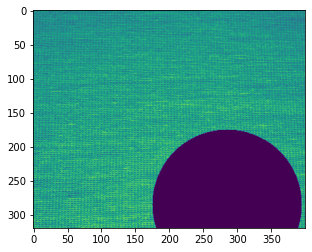

85


In [64]:
plt.imshow(dst2)
plt.show()

print(dst2[0, 0])

In [68]:
np.array([4,6])/2

array([2., 3.])

In [70]:
dst2 = cv2.subtract(img1_gray, np.array(img1_bg)/2) # 进行融合


error: OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\core\src\arithm.cpp:674: error: (-5:Bad argument) When the input arrays in add/subtract/multiply/divide functions have different types, the output array type must be explicitly specified in function 'cv::arithm_op'


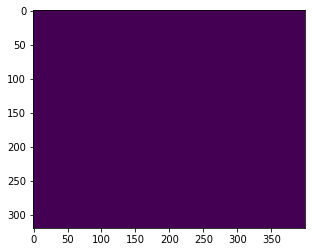

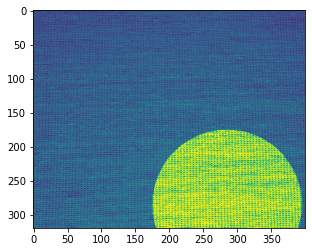

In [59]:
Mask1 = np.zeros((img1.shape[0], img1.shape[1]), dtype=np.uint8)  # 返回与图像 img1 尺寸相同的全零数组
Mask2 = Mask1.copy()

plt.imshow(Mask1)
plt.show()

cv2.circle(Mask1, (285, 285), 110, (255, 255, 255), -1)  # -1 表示实心

imgAddMask1 = cv2.add(img1_gray, np.zeros(np.shape(img1_gray), dtype=np.uint8), mask=Mask1)  # 提取圆形 ROI
img1_bg = cv2.bitwise_and(img1_gray, img1_gray, mask=imgAddMask1)
dst = cv2.add(img1_gray, img1_bg) # 进行融合

plt.imshow(dst)
plt.show()


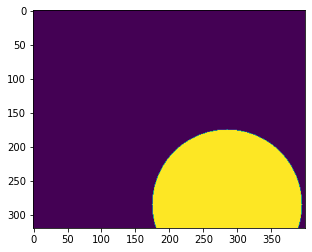

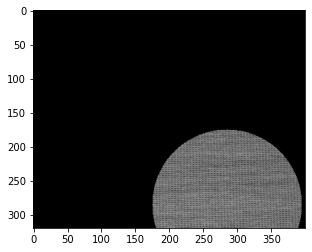

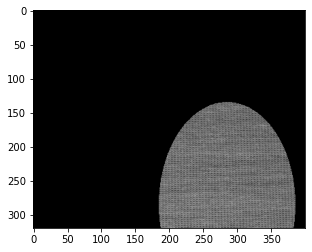

In [5]:
# 1.28 图像的加法 (圆形和其它形状的遮罩)
Mask1 = np.zeros((img1.shape[0], img1.shape[1]), dtype=np.uint8)  # 返回与图像 img1 尺寸相同的全零数组
Mask2 = Mask1.copy()

cv2.circle(Mask1, (285, 285), 110, (255, 255, 255), -1)  # -1 表示实心
cv2.ellipse(Mask2, (285, 285), (100, 150), 0, 0, 360, 255, -1)  # -1 表示实心

imgAddMask1 = cv2.add(img1_gray, np.zeros(np.shape(img1_gray), dtype=np.uint8), mask=Mask1)  # 提取圆形 ROI
imgAddMask2 = cv2.add(img1, np.zeros(np.shape(img1), dtype=np.uint8), mask=Mask2)  # 提取椭圆 ROI

plt.imshow(Mask1)  # 显示掩模图像 Mask
plt.show()
plt.imshow(imgAddMask1)  # 显示掩模加法结果 imgAddMask1
plt.show()
plt.imshow(imgAddMask2)  # 显示掩模加法结果 imgAddMask2
plt.show()


# Line

In [100]:
img1_gray.shape

(320, 400)

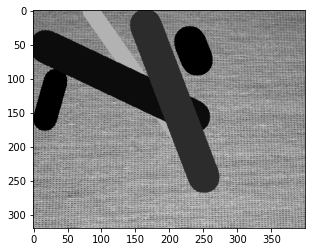

In [105]:
# 畫粗度為7的紅色線
start_positon = (random.randrange(0,  w),  random.randrange(0,  h))
end_positon = (random.randrange(0,  w),  random.randrange(0,  h))
defect_width =  random.randrange(5,  int(w/5))
img = cv2.line(img1_gray, start_positon,end_positon, (32), defect_width)
plt.imshow(img, 'gray')
plt.show()

# Ellipse

In [81]:
w, h =256, 256
# detection's width height
detect_w = random.randrange(10, 100)
detect_h = random.randrange(int(detect_w/4), int(detect_w*2))

# position center's x,y
detect_x, detect_y = random.randrange(0, w), random.randrange(0, h)
#水平開始向逆時針偏移
cur_angle = random.randrange(0, 45)
#繪製角度由0~180度的
strat_ellipse = random.randrange(0, 100)
end_ellipse = random.choice([110, 270,360])

defect_data = copy.deepcopy(img3)
# 中心座標是(256, 256)，長軸短軸分別是(70, 30)，由水平開始向逆時針偏移15度，繪製角度由0~180度的實心橢圓
img = cv2.ellipse(defect_data, (detect_x,detect_y), (detect_w,detect_h), cur_angle, strat_ellipse, end_ellipse, (0,0,255), -1)

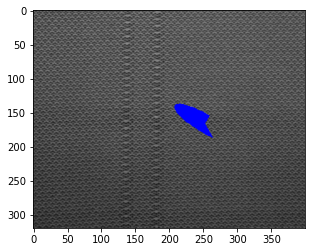

# Circle


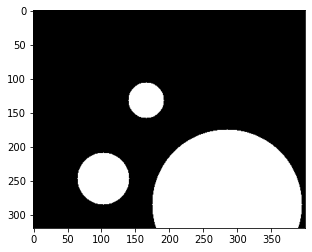

In [98]:
# detection's width height
detect_w = random.randrange(10, 100)
detect_h = random.randrange(int(detect_w/4), int(detect_w*2))
# position center's x,y
detect_x, detect_y = random.randrange(0, w), random.randrange(0, h)
defect_radio = random.randrange(10, 40)
dst = cv2.circle(Mask1, (detect_x, detect_y), defect_radio, (255, 255, 255), -1)  # -1 表示实心
plt.imshow(dst, 'gray')
plt.show()


In [113]:
w,h = img1_gray.shape

In [114]:
def generator_defect(gray_image, gen_type = 1):
    
    detect_w, detect_h = img1_gray.shape
    
    defect_data = copy.deepcopy(gray_image)
    defect_label = np.zeros(np.shape(defect_data), dtype=np.uint8)  # 返回与图像 img1 尺寸相同的全零数组
    defect_value = random.randrange(0, 255)
    
    if gen_type == 0:
        # ellipse
        # detection's width height
        detect_w = random.randrange(10, 100)
        detect_h = random.randrange(int(detect_w/4), int(detect_w*2))
        # position center's x,y
        detect_x, detect_y = random.randrange(0, detect_w), random.randrange(0, detect_h)
        #水平開始向逆時針偏移
        cur_angle = random.randrange(0, 45)
        #繪製角度由0~180度的
        strat_ellipse = random.randrange(0, 100)
        end_ellipse = random.choice([110, 270,360])

        # 中心座標是(256, 256)，長軸短軸分別是(70, 30)，由水平開始向逆時針偏移15度，繪製角度由0~180度的實心橢圓
        cv2.ellipse(defect_data, (detect_x,detect_y), (detect_w,detect_h), cur_angle, strat_ellipse, end_ellipse, (defect_value), -1)
        cv2.ellipse(defect_label, (detect_x,detect_y), (detect_w,detect_h), cur_angle, strat_ellipse, end_ellipse, (1), -1)
        defect_label
        
    elif gen_type == 1:
        # 畫粗度為7的紅色線
        start_positon = (random.randrange(0,  detect_w),  random.randrange(0,  detect_h))
        end_positon = (random.randrange(0,  detect_w),  random.randrange(0,  detect_h))
        defect_width =  random.randrange(5,  int(w/5))
        cv2.line(defect_data, start_positon,end_positon, (defect_value), defect_width)
        cv2.line(defect_label, start_positon,end_positon, (1), defect_width)

    elif gen_type == 2:
        # detection's width height
        detect_w = random.randrange(10, 100)
        detect_h = random.randrange(int(detect_w/4), int(detect_w*2))
        # position center's x,y
        detect_x, detect_y = random.randrange(0, detect_w), random.randrange(0, detect_h)
        defect_radio = random.randrange(10, 40)
        cv2.circle(defect_data, (detect_x, detect_y), defect_radio, (defect_value), -1)  # -1 表示实心
        cv2.circle(defect_label, (detect_x, detect_y), defect_radio, (1), -1)  # -1 表示实心
    
    #imgAddMask1 = cv2.add(defect_data, np.zeros(np.shape(defect_data), dtype=np.uint8), mask=defect_data)  # 提取圆形 ROI
    
    return defect_data, defect_label


In [118]:
print(img3_label[0,0])

0


In [115]:
img3_image, img3_label = generator_defect(img3_gray)

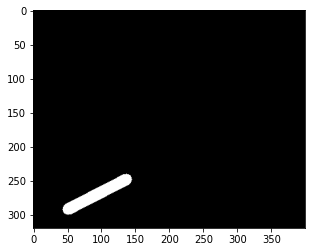

In [117]:
plt.imshow(img3_label, 'gray')
plt.show()

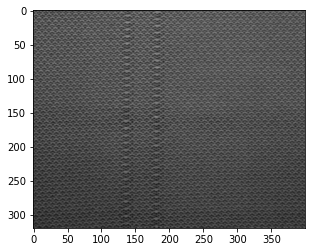

In [32]:
plt.imshow(img3)
plt.show()

In [8]:
def gen_defect(image):
    h, w = image.shape
    label = np.zeros((h, w))
    image_label = copy.deepcopy(label)
    image_ad = copy.deepcopy(image)

    Mask = ['round', 'rectangle']
    Defect = [0, 1, 2] # ['rotation', 'alteration', 'shadow']

    cur_mask = random.choice(Mask)
    cur_defect = random.choice(Defect)

    #detect_img =  copy.deepcopy(img)
    for defect_idx in range(1):
        # detection's width height
        detect_w, detect_h = random.randrange(7, 15), random.randrange(310, 320)
        # position's x,y
        detect_x, detect_y = random.randrange(0, w - detect_w), random.randrange(0, h - detect_h)

        if cur_defect == 0:
            cur_angle = 45 #random.randrange(-45, 45)
            cur_scale = 1 #random.uniform(1.2, 2)
            rotateMatrix = cv2.getRotationMatrix2D((w / 2, h / 2), cur_angle, cur_scale)
            rotated = cv2.warpAffine(image, rotateMatrix, (w, h))
            center_x, center_y = int((w - detect_w) /2) , int((h -detect_w) /2)
            ad = rotated[center_y:center_y + detect_h, center_x:center_x + detect_w]
        elif cur_defect == 1:
            (mean, stddv) = cv2.meanStdDev(image)
            ad = np.ones([detect_h,detect_w]) * mean - 20
        elif cur_defect == 2:
            (mean, stddv) = cv2.meanStdDev(image)
            ad = np.ones([detect_h,detect_w]) * mean + 20

        ad_h, ad_w = ad.shape
        image_ad[detect_y: detect_y + ad_h,detect_x: detect_x + ad_w] = ad
        ad_label = np.ones((ad_h, ad_w)) * 255
        image_label[detect_y: detect_y + ad_h,detect_x: detect_x + ad_w] = ad_label

    image_ad = np.array(image_ad)
    # avoid overflow
    image_ad = np.where(image_ad > 255, 255, image_ad)
    image_ad = np.where(image_ad < 0, 0, image_ad)

    return image_ad, image_label

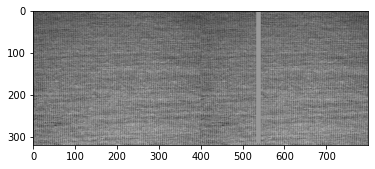

In [9]:
image_ad, image_label = gen_defect(img1_gray)

plt.imshow(np.concatenate((img1_gray, image_ad), axis = 1), 'gray')

In [124]:
data2 = np.concatenate((img1_gray, image_ad), axis = 1)

In [134]:
img1_gray_reshape = img1_gray.reshape(320,400, 1)
img2_gray_reshape = img2_gray.reshape(320,400, 1)

In [135]:
data2 = np.concatenate((img1_gray_reshape, img2_gray_reshape), axis = 2)

In [141]:
np.ones(45)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras_cv_attention_models.attention_layers import (
    ChannelAffine,
    MultiHeadRelativePositionalEmbedding,
    activation_by_name,
    conv2d_no_bias,
    depthwise_conv2d_no_bias,
    drop_block,
    layer_norm,
    mhsa_with_multi_head_relative_position_embedding,
    mlp_block,
    output_block,
    se_module,
    window_attention,
    add_pre_post_process,
)
from keras_cv_attention_models.download_and_load import reload_model_weights

PRETRAINED_DICT = {
    "gcvit_xx_tiny": {"imagenet": {224: "ff516a5a1d3dfdda0c0b2e0051206c00"}},
    "gcvit_x_tiny": {"imagenet": {224: "723155237e083716bb3df904c80711c4"}},
    "gcvit_tiny": {"imagenet": {224: "0e6ecf576b649f7077f4f2f8122b420e"}},
    "gcvit_small": {"imagenet": {224: "ac0cfb4240ae85a40a88691c2329edab"}},
    "gcvit_base": {"imagenet": {224: "ef6e4015239f68dcabbb8ae9cb799d76"}},
}


def gcvit_block(inputs, window_size, num_heads=4, global_query=None, mlp_ratio=4, layer_scale=0, drop_rate=0, activation="gelu", name=""):
    # print(global_query)
    input_channel = inputs.shape[-1]
    attn = layer_norm(inputs, name=name + "attn_")
    attention_block = lambda inputs, num_heads, name: mhsa_with_multi_head_relative_position_embedding(
        inputs, num_heads=num_heads, global_query=global_query, qkv_bias=True, out_bias=True, name=name
    )
    attn = window_attention(attn, window_size=window_size, num_heads=num_heads, attention_block=attention_block, name=name + "window_mhsa_")
    attn = ChannelAffine(use_bias=False, weight_init_value=layer_scale, name=name + "1_gamma")(attn) if layer_scale >= 0 else attn
    attn = drop_block(attn, drop_rate=drop_rate, name=name + "attn_")
    attn_out = keras.layers.Add(name=name + "attn_out")([inputs, attn])

    mlp = layer_norm(attn_out, name=name + "mlp_")
    mlp = mlp_block(mlp, int(input_channel * mlp_ratio), use_conv=False, activation=activation, name=name + "mlp_")
    mlp = ChannelAffine(use_bias=False, weight_init_value=layer_scale, name=name + "2_gamma")(mlp) if layer_scale >= 0 else mlp
    mlp = drop_block(mlp, drop_rate=drop_rate, name=name + "mlp_")
    return keras.layers.Add(name=name + "output")([attn_out, mlp])


def to_global_query(inputs, window_ratio, num_heads=4, activation="gelu", name=""):
    input_channel = inputs.shape[-1]
    query = inputs
    num_window = 1
    if window_ratio == 1:
        query = extract_feature(query, strides=1, activation=activation, name=name + "down1_")
    else:
        while num_window < window_ratio:
            num_window *= 2
            query = extract_feature(query, strides=2, activation=activation, name=name + "down{}_".format(num_window))

    # print(f"{inputs.shape = }, {query.shape = }, {num_window = }, {window_ratio = }")
    query = tf.reshape(query, [-1, query.shape[1] * query.shape[2], num_heads, input_channel // num_heads])
    query = tf.transpose(query, [0, 2, 1, 3])
    query = tf.repeat(query, num_window * num_window, axis=0)
    # print(f"{query.shape = }")
    return query


def down_sample(inputs, out_channels=-1, activation="gelu", name=""):
    out_channels = out_channels if out_channels > 0 else inputs.shape[-1]
    nn = layer_norm(inputs, name=name + "down_1_")
    nn = extract_feature(nn, strides=1, activation=activation, name=name + "down_")
    nn = conv2d_no_bias(nn, out_channels, kernel_size=3, strides=2, padding="same", name=name + "down_")
    nn = layer_norm(nn, name=name + "down_2_")
    return nn


def extract_feature(inputs, strides=2, activation="gelu", name=""):
    input_channel = inputs.shape[-1]
    nn = depthwise_conv2d_no_bias(inputs, kernel_size=3, padding="same", name=name + "extract_")
    nn = activation_by_name(nn, activation=activation, name=name + "extract_")
    nn = se_module(nn, divisor=1, use_bias=False, activation=activation, use_conv=False, name=name + "extract_se_")
    nn = conv2d_no_bias(nn, input_channel, kernel_size=1, name=name + "extract_")
    nn = inputs + nn
    return keras.layers.MaxPool2D(pool_size=3, strides=strides, padding="SAME", name=name + "extract_maxpool")(nn) if strides > 1 else nn
    # if strides > 1:
    #     nn = tf.pad(nn, [[0, 0], [1, 1], [1, 1], [0, 0]])
    #     nn = keras.layers.MaxPool2D(pool_size=3, strides=strides, padding="VALID", name=name + "extract_maxpool")(nn)
    # return nn


def GCViT(
    num_blocks=[2, 2, 6, 2],
    num_heads=[2, 4, 8, 16],
    # window_size=[7, 7, 14, 7],
    window_ratios=[8, 4, 1, 1],
    embed_dim=64,
    mlp_ratio=3,
    layer_scale=-1,
    input_shape=(224, 224, 3),
    num_classes=1000,
    activation="gelu",
    drop_connect_rate=0,
    classifier_activation="softmax",
    dropout=0,
    pretrained=None,
    model_name="gcvit",
    kwargs=None,
):
    """Patch stem"""
    inputs = keras.layers.Input(input_shape)
    nn = conv2d_no_bias(inputs, embed_dim, kernel_size=3, strides=2, use_bias=True, padding="SAME", name="stem_conv")
    nn = down_sample(nn, name="stem_")

    """ stages """
    total_blocks = sum(num_blocks)
    global_block_id = 0
    num_stacks = len(num_blocks)
    for stack_id, (num_block, num_head, window_ratio) in enumerate(zip(num_blocks, num_heads, window_ratios)):
        stack_name = "stack{}_".format(stack_id + 1)
        if stack_id > 0:
            nn = down_sample(nn, out_channels=nn.shape[-1] * 2, name=stack_name)

        window_size = (nn.shape[1] // window_ratio, nn.shape[2] // window_ratio)
        # window_size = (int(tf.math.ceil(nn.shape[1] / window_ratio), int(tf.math.ceil(nn.shape[2] / window_ratio))
        global_query = to_global_query(nn, window_ratio, num_head, activation=activation, name=stack_name + "q_global_")

        for block_id in range(num_block):
            block_name = stack_name + "block{}_".format(block_id + 1)
            block_drop_rate = drop_connect_rate * global_block_id / total_blocks
            cur_global_query = None if block_id % 2 == 0 else global_query
            nn = gcvit_block(nn, window_size, num_head, cur_global_query, mlp_ratio, layer_scale, block_drop_rate, activation=activation, name=block_name)
            global_block_id += 1
    nn = layer_norm(nn, name="pre_output_")

    nn = output_block(nn, num_classes=num_classes, drop_rate=dropout, classifier_activation=classifier_activation)
    model = keras.models.Model(inputs, nn, name=model_name)
    add_pre_post_process(model, rescale_mode="torch")
    reload_model_weights(model, PRETRAINED_DICT, "gcvit", pretrained, MultiHeadRelativePositionalEmbedding)
    return model


def GCViT_XXTiny(input_shape=(224, 224, 3), num_classes=1000, activation="gelu", classifier_activation="softmax", pretrained=None, **kwargs):
    return GCViT(**locals(), model_name="gcvit_xx_tiny", **kwargs)


def GCViT_XTiny(input_shape=(224, 224, 3), num_classes=1000, activation="gelu", classifier_activation="softmax", pretrained=None, **kwargs):
    num_blocks = [3, 4, 6, 5]
    return GCViT(**locals(), model_name="gcvit_x_tiny", **kwargs)


def GCViT_Tiny(input_shape=(224, 224, 3), num_classes=1000, activation="gelu", classifier_activation="softmax", pretrained="imagenet", **kwargs):
    num_blocks = [3, 4, 19, 5]
    return GCViT(**locals(), model_name="gcvit_tiny", **kwargs)


def GCViT_Small(input_shape=(224, 224, 3), num_classes=1000, activation="gelu", classifier_activation="softmax", pretrained="imagenet", **kwargs):
    num_blocks = [3, 4, 19, 5]
    num_heads = [3, 6, 12, 24]
    embed_dim = 96
    mlp_ratio = 2
    layer_scale = 1e-5
    return GCViT(**locals(), model_name="gcvit_small", **kwargs)


def GCViT_Base(input_shape=(224, 224, 3), num_classes=1000, activation="gelu", classifier_activation="softmax", pretrained="imagenet", **kwargs):
    num_blocks = [3, 4, 19, 5]
    num_heads = [4, 8, 16, 32]
    embed_dim = 128
    mlp_ratio = 2
    layer_scale = 1e-5
    return GCViT(**locals(), model_name="gcvit_base", **kwargs)

C:\Users\kaka\miniconda3\envs\ICPR2023\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model = GCViT_XXTiny()
model.summary()

Model: "gcvit_xx_tiny"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_convpad (ZeroPadding2D)   (None, 226, 226, 3)  0           ['input_2[0][0]']                
                                                                                                  
 stem_convconv (Conv2D)         (None, 112, 112, 64  1792        ['stem_convpad[0][0]']           
                                )                                                                 
                                                                                      

 pLambda)                                                                                         
                                                                                                  
 stack1_q_global_down2_extract_  (None, 1, 1, 64)    0           ['stack1_q_global_down2_extract_s
 se_sigmoid (Activation)                                         e_2_dense[0][0]']                
                                                                                                  
 tf.reshape_102 (TFOpLambda)    (None, 7, 7, 64)     0           ['tf.compat.v1.transpose_71[0][0]
                                                                 ']                               
                                                                                                  
 stack1_q_global_down2_extract_  (None, 56, 56, 64)  0           ['stack1_q_global_down2_extract_g
 se_out (Multiply)                                               elu[0][0]',                      
          

 tf.compat.v1.transpose_75 (TFO  (None, 49, 2, 32)   0           ['lambda_25[0][0]']              
 pLambda)                                                                                         
                                                                                                  
 stack1_q_global_down4_extract_  (None, 1, 1, 64)    1024        ['stack1_q_global_down4_extract_s
 se_2_dense (Dense)                                              e_gelu[0][0]']                   
                                                                                                  
 tf.reshape_106 (TFOpLambda)    (None, 7, 7, 64)     0           ['tf.compat.v1.transpose_75[0][0]
                                                                 ']                               
                                                                                                  
 stack1_q_global_down4_extract_  (None, 1, 1, 64)    0           ['stack1_q_global_down4_extract_s
 se_sigmoi

 stack1_q_global_down8_extract_  (None, 1, 1, 64)    0           ['stack1_q_global_down8_extract_s
 se_sigmoid (Activation)                                         e_2_dense[0][0]']                
                                                                                                  
 tf.reshape_109 (TFOpLambda)    (None, 7, 8, 448)    0           ['stack1_block2_attn_ln[0][0]']  
                                                                                                  
 stack1_q_global_down8_extract_  (None, 14, 14, 64)  0           ['stack1_q_global_down8_extract_g
 se_out (Multiply)                                               elu[0][0]',                      
                                                                  'stack1_q_global_down8_extract_s
                                                                 e_sigmoid[0][0]']                
                                                                                                  
 tf.compat

 tf.reshape_115 (TFOpLambda)    (None, 8, 7, 448)    0           ['stack1_block2_window_mhsa_outpu
                                                                 t[0][0]']                        
                                                                                                  
 tf.compat.v1.transpose_81 (TFO  (None, 7, 8, 448)   0           ['tf.reshape_115[0][0]']         
 pLambda)                                                                                         
                                                                                                  
 tf.reshape_116 (TFOpLambda)    (None, 56, 56, 64)   0           ['tf.compat.v1.transpose_81[0][0]
                                                                 ']                               
                                                                                                  
 stack1_block2_attn_out (Add)   (None, 56, 56, 64)   0           ['stack1_block1_output[0][0]',   
          

                                                                 ']                               
                                                                                                  
 stack2_block1_window_mhsa_qkv_  (None, 7, 7, 384)   49536       ['tf.reshape_119[0][0]']         
 conv (Conv2D)                                                                                    
                                                                                                  
 tf.split_14 (TFOpLambda)       [(None, 7, 7, 128),  0           ['stack2_block1_window_mhsa_qkv_c
                                 (None, 7, 7, 128),              onv[0][0]']                      
                                 (None, 7, 7, 128)]                                               
                                                                                                  
 tf.reshape_120 (TFOpLambda)    (None, 49, 4, 32)    0           ['tf.split_14[0][0]']            
          

                                                                 t[0][0]']                        
                                                                                                  
 stack2_q_global_down2_extract_  (None, 28, 28, 128)  16384      ['stack2_q_global_down2_extract_s
 conv (Conv2D)                                                   e_out[0][0]']                    
                                                                                                  
 tf.compat.v1.transpose_88 (TFO  (None, 7, 4, 896)   0           ['tf.reshape_124[0][0]']         
 pLambda)                                                                                         
                                                                                                  
 tf.__operators__.add_16 (TFOpL  (None, 28, 28, 128)  0          ['stack2_down_2_ln[0][0]',       
 ambda)                                                           'stack2_q_global_down2_extract_c
          

                                                                 onv[0][0]']                      
                                                                                                  
 stack2_block2_window_mhsa_kv_c  (None, 7, 7, 256)   33024       ['tf.reshape_127[0][0]']         
 onv (Conv2D)                                                                                     
                                                                                                  
 stack2_q_global_down4_extract_  (None, 7, 7, 128)   0           ['tf.__operators__.add_17[0][0]']
 maxpool (MaxPooling2D)                                                                           
                                                                                                  
 tf.reshape_128 (TFOpLambda)    (None, 49, 256)      0           ['stack2_block2_window_mhsa_kv_co
                                                                 nv[0][0]']                       
          

 se)                                                                                              
                                                                                                  
 stack2_block2_output (Add)     (None, 28, 28, 128)  0           ['stack2_block2_attn_out[0][0]', 
                                                                  'stack2_block2_mlp_Dense_1[0][0]
                                                                 ']                               
                                                                                                  
 stack3_down_1_ln (LayerNormali  (None, 28, 28, 128)  256        ['stack2_block2_output[0][0]']   
 zation)                                                                                          
                                                                                                  
 stack3_down_extract_dw_pad (Ze  (None, 30, 30, 128)  0          ['stack3_down_1_ln[0][0]']       
 roPadding

 lambda_32 (Lambda)             (None, 8, 196, 196)  0           ['tf.compat.v1.transpose_96[0][0]
                                                                 ',                               
                                                                  'tf.compat.v1.transpose_97[0][0]
                                                                 ']                               
                                                                                                  
 tf.math.multiply_16 (TFOpLambd  (None, 8, 196, 196)  0          ['lambda_32[0][0]']              
 a)                                                                                               
                                                                                                  
 stack3_block1_window_mhsa_pos_  (None, 8, 196, 196)  5832       ['tf.math.multiply_16[0][0]']    
 emb (MultiHeadRelativePosition                                                                   
 alEmbeddi

 stack3_q_global_down1_extract_  (None, 1, 1, 256)   16384       ['stack3_q_global_down1_extract_s
 se_2_dense (Dense)                                              e_gelu[0][0]']                   
                                                                                                  
 tf.reshape_143 (TFOpLambda)    (None, 14, 1, 3584)  0           ['stack3_block2_attn_ln[0][0]']  
                                                                                                  
 stack3_q_global_down1_extract_  (None, 1, 1, 256)   0           ['stack3_q_global_down1_extract_s
 se_sigmoid (Activation)                                         e_2_dense[0][0]']                
                                                                                                  
 tf.compat.v1.transpose_101 (TF  (None, 1, 14, 3584)  0          ['tf.reshape_143[0][0]']         
 OpLambda)                                                                                        
          

                                                                                                  
 tf.compat.v1.transpose_105 (TF  (None, 14, 1, 3584)  0          ['tf.reshape_149[0][0]']         
 OpLambda)                                                                                        
                                                                                                  
 tf.reshape_150 (TFOpLambda)    (None, 14, 14, 256)  0           ['tf.compat.v1.transpose_105[0][0
                                                                 ]']                              
                                                                                                  
 stack3_block2_attn_out (Add)   (None, 14, 14, 256)  0           ['stack3_block1_output[0][0]',   
                                                                  'tf.reshape_150[0][0]']         
                                                                                                  
 stack3_bl

 OpLambda)                                                                                        
                                                                                                  
 tf.reshape_156 (TFOpLambda)    (None, 14, 14, 256)  0           ['tf.compat.v1.transpose_110[0][0
                                                                 ]']                              
                                                                                                  
 stack3_block3_window_mhsa_outp  (None, 14, 14, 256)  65792      ['tf.reshape_156[0][0]']         
 ut (Dense)                                                                                       
                                                                                                  
 tf.reshape_157 (TFOpLambda)    (None, 1, 14, 3584)  0           ['stack3_block3_window_mhsa_outpu
                                                                 t[0][0]']                        
          

                                                                 ]']                              
                                                                                                  
 tf.compat.v1.transpose_115 (TF  (None, 196, 8, 32)  0           ['lambda_39[0][0]']              
 OpLambda)                                                                                        
                                                                                                  
 tf.reshape_164 (TFOpLambda)    (None, 14, 14, 256)  0           ['tf.compat.v1.transpose_115[0][0
                                                                 ]']                              
                                                                                                  
 stack3_block4_window_mhsa_outp  (None, 14, 14, 256)  65792      ['tf.reshape_164[0][0]']         
 ut (Dense)                                                                                       
          

                                                                                                  
 stack3_block5_window_mhsa_atte  (None, 8, 196, 196)  0          ['stack3_block5_window_mhsa_pos_e
 ntion_scores (Softmax)                                          mb[0][0]']                       
                                                                                                  
 tf.compat.v1.transpose_120 (TF  (None, 8, 196, 32)  0           ['tf.reshape_171[0][0]']         
 OpLambda)                                                                                        
                                                                                                  
 lambda_41 (Lambda)             (None, 8, 196, 32)   0           ['stack3_block5_window_mhsa_atten
                                                                 tion_scores[0][0]',              
                                                                  'tf.compat.v1.transpose_120[0][0
          

 alEmbedding)                                                                                     
                                                                                                  
 tf.reshape_179 (TFOpLambda)    (None, 196, 8, 32)   0           ['tf.split_21[0][1]']            
                                                                                                  
 stack3_block6_window_mhsa_atte  (None, 8, 196, 196)  0          ['stack3_block6_window_mhsa_pos_e
 ntion_scores (Softmax)                                          mb[0][0]']                       
                                                                                                  
 tf.compat.v1.transpose_125 (TF  (None, 8, 196, 32)  0           ['tf.reshape_179[0][0]']         
 OpLambda)                                                                                        
                                                                                                  
 lambda_43

 stack4_down_extract_conv (Conv  (None, 14, 14, 256)  65536      ['stack4_down_extract_se_out[0][0
 2D)                                                             ]']                              
                                                                                                  
 tf.__operators__.add_20 (TFOpL  (None, 14, 14, 256)  0          ['stack4_down_1_ln[0][0]',       
 ambda)                                                           'stack4_down_extract_conv[0][0]'
                                                                 ]                                
                                                                                                  
 stack4_down_pad (ZeroPadding2D  (None, 16, 16, 256)  0          ['tf.__operators__.add_20[0][0]']
 )                                                                                                
                                                                                                  
 stack4_do

 tf.reshape_191 (TFOpLambda)    (None, 7, 7, 512)    0           ['tf.compat.v1.transpose_134[0][0
                                                                 ]']                              
                                                                                                  
 stack4_block1_attn_out (Add)   (None, 7, 7, 512)    0           ['stack4_down_2_ln[0][0]',       
                                                                  'tf.reshape_191[0][0]']         
                                                                                                  
 stack4_block1_mlp_ln (LayerNor  (None, 7, 7, 512)   1024        ['stack4_block1_attn_out[0][0]'] 
 malization)                                                                                      
                                                                                                  
 stack4_q_global_down1_extract_  (None, 9, 9, 512)   0           ['stack4_down_2_ln[0][0]']       
 dw_pad (Z

 tf.reshape_195 (TFOpLambda)    (None, 49, 16, 32)   0           ['tf.split_23[0][0]']            
                                                                                                  
 tf.repeat_7 (TFOpLambda)       (None, 16, 49, 32)   0           ['tf.compat.v1.transpose_128[0][0
                                                                 ]']                              
                                                                                                  
 tf.compat.v1.transpose_136 (TF  (None, 16, 32, 49)  0           ['tf.reshape_195[0][0]']         
 OpLambda)                                                                                        
                                                                                                  
 lambda_46 (Lambda)             (None, 16, 49, 49)   0           ['tf.repeat_7[0][0]',            
                                                                  'tf.compat.v1.transpose_136[0][0
          

In [2]:
!pip3 install keras_cv_attention_models


  Using cached tensorflow_estimator-2.11.0-py2.py3-none-any.whl (439 kB)
  Using cached tensorboard-2.11.0-py3-none-any.whl (6.0 MB)
  Using cached keras-2.11.0-py2.py3-none-any.whl (1.7 MB)
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-gpu 2.9.0 requires flatbuffers<2,>=1.12, but you have flatbuffers 22.12.6 which is incompatible.
tensorflow-gpu 2.9.0 requires keras<2.10.0,>=2.9.0rc0, but you have keras 2.11.0 which is incompatible.
tensorflow-gpu 2.9.0 requires tensorboard<2.10,>=2.9, but you have tensorboard 2.11.0 which is incompatible.
tensorflow-gpu 2.9.0 requires tensorflow-estimator<2.10.0,>=2.9.0rc0, but you have tensorflow-estimator 2.11.0 which is incompatible.
You should consider upgrading via the 'C:\Users\kaka\PycharmProjects\pythonProject\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [1]:

from __future__ import absolute_import

from model.keras_unet_collection._model_unet_2d import unet_2d
from model.keras_unet_collection._model_vnet_2d import vnet_2d
from model.keras_unet_collection._model_unet_plus_2d import unet_plus_2d
from model.keras_unet_collection._model_r2_unet_2d import r2_unet_2d
from model.keras_unet_collection._model_att_unet_2d import att_unet_2d
from model.keras_unet_collection._model_resunet_a_2d import resunet_a_2d
from model.keras_unet_collection._model_u2net_2d import u2net_2d
from model.keras_unet_collection._model_unet_3plus_2d import unet_3plus_2d
from model.keras_unet_collection._model_transunet_2d import transunet_2d
from model.keras_unet_collection._model_swin_unet_2d import swin_unet_2d

ModuleNotFoundError: No module named 'keras_unet_collection'